In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# Several helpful packages to load

import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

In [2]:
EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'} # surprise je promenjen sa 8 na 0
DATA_PATH = './inputs/Audio_Speech_Actors_01-24/'
SAMPLE_RATE = 48000

In [8]:
data = pd.DataFrame(columns=['Emotion', 'Intensity', 'Gender','Path'])

for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        identifiers = filename.split('.')[0].split('-')
        emotion = (int(identifiers[2]))
        if emotion == 8: # promeni surprise sa 8 na 0
            emotion = 0
        if int(identifiers[3]) == 1:
            emotion_intensity = 'normal' 
        else:
            emotion_intensity = 'strong'
        if int(identifiers[6])%2 == 0:
            gender = 'female'
        else:
            gender = 'male'
        
        data = data.append({"Emotion": emotion,
                            "Intensity": emotion_intensity,
                            "Gender": gender,
                            "Path": file_path
                             },
                             ignore_index = True
                          )
print("number of files is {}".format(len(data)))
data.head()

number of files is 1440


,Emotion,Intensity,Gender,Path
0,5,normal,female,./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
1,6,normal,female,./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
2,6,strong,female,./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
3,5,strong,female,./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
4,7,normal,female,./inputs/Audio_Speech_Actors_01-24/Actor_16/03...


Text(0, 0.5, 'Number of examples')

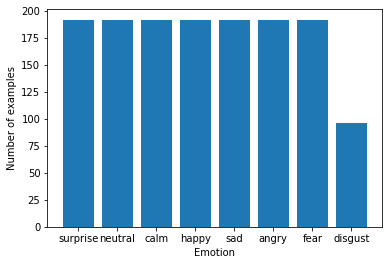

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=range(8), height=data['Emotion'].value_counts())
ax.set_xticks(ticks=range(8))
ax.set_xticklabels([EMOTIONS[i] for i in range(8)],fontsize=10)
ax.set_xlabel('Emotion')
ax.set_ylabel('Number of examples')

Text(0, 0.5, 'Number of examples')

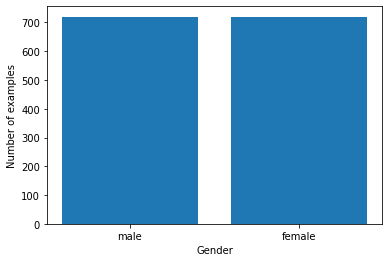

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = data['Gender'].value_counts()
ax.bar(x=[0,1], height=counts.values)
ax.set_xticks(ticks=[0,1])
ax.set_xticklabels(list(counts.index))
ax.set_xlabel('Gender')
ax.set_ylabel('Number of examples')

Text(0, 0.5, 'Number of examples')

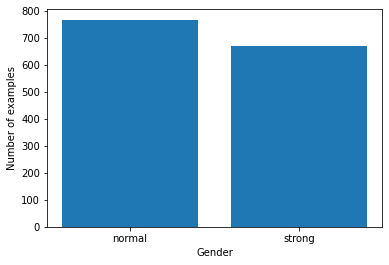

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = data['Intensity'].value_counts()
ax.bar(x=[0,1], height=counts.values)
ax.set_xticks(ticks=[0,1])
ax.set_xticklabels(list(counts.index))
ax.set_xlabel('Gender')
ax.set_ylabel('Number of examples')

### CALCULATE MEL SPECTROGRAM

Mel-spectrogram shape:  (128, 563)


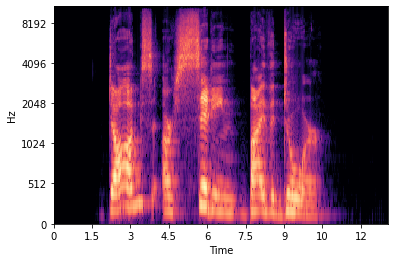

In [15]:
def getMELspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# test function
audio, sample_rate = librosa.load(data.loc[0,'Path'], duration=3, offset=0.5,sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3,)))
signal[:len(audio)] = audio
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
print('Mel-spectrogram shape: ',mel_spectrogram.shape)

In [16]:
mel_spectrograms = []
signals = []
for i, file_path in enumerate(data.Path):
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3,)))
    signal[:len(audio)] = audio
    signals.append(signal)
    mel_spectrogram = getMELspectrogram(signal, sample_rate=SAMPLE_RATE)
    mel_spectrograms.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,len(data)),end='')

 Processed 1439/1440 files

In [17]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30): 
    signal_len = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    # Compute K (covariance matrix) for each noise 
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K  
    # Generate noisy signal
    return signal + K.T * noise

In [18]:
for i,signal in enumerate(signals):
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        mel_spectrogram = getMELspectrogram(augmented_signals[j,:], sample_rate=SAMPLE_RATE)
        mel_spectrograms.append(mel_spectrogram)
        data = data.append(data.iloc[i], ignore_index=True)
    print("\r Processed {}/{} files".format(i,len(signals)),end='')

 Processed 1439/1440 files

### SPLIT SPECTROGRAM INTO CHUNKS

In [20]:
def splitIntoChunks(mel_spec,win_size,stride):
    t = mel_spec.shape[1]
    num_of_chunks = int(t/stride)
    chunks = []
    for i in range(num_of_chunks):
        chunk = mel_spec[:,i*stride:i*stride+win_size]
        if chunk.shape[1] == win_size:
            chunks.append(chunk)
    return np.stack(chunks,axis=0)

In [21]:
# get chunks
mel_spectrograms_chunked = []
for mel_spec in mel_spectrograms:
    chunks = splitIntoChunks(mel_spec, win_size=128,stride=64)
    mel_spectrograms_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))

Number of chunks is 7


### CREATE MODEL

In [23]:
import torch
import torch.nn as nn
# BATCH FIRST TimeDistributed layer
class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)
        # squash samples and timesteps into a single axis
        elif x.size() == 3: # (samples, timesteps, inp1)
            x_reshape = x.contiguous().view(-1, x.size(2))  # (samples * timesteps, inp1)
        elif x.size() == 4: # (samples,timesteps,inp1,inp2)
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3)) # (samples*timesteps,inp1,inp2)
        else: # (samples,timesteps,inp1,inp2,inp3)
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3),x.size(4)) # (samples*timesteps,inp1,inp2,inp3)
            
        y = self.module(x_reshape)
        
        # we have to reshape Y
        if x.size() == 3:
            y = y.contiguous().view(x.size(0), -1, y.size(1))  # (samples, timesteps, out1)
        elif x.size() == 4:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2)) # (samples, timesteps, out1,out2)
        else:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2),y.size(3)) # (samples, timesteps, out1,out2, out3)
        return y

In [24]:
class HybridModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        # conv block
        self.conv2Dblock = nn.Sequential(
            # 1. conv block
            TimeDistributed(nn.Conv2d(in_channels=1,
                                   out_channels=16,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(16)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=2, stride=2)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 2. conv block
            TimeDistributed(nn.Conv2d(in_channels=16,
                                   out_channels=32,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(32)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 3. conv block
            TimeDistributed(nn.Conv2d(in_channels=32,
                                   out_channels=64,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(64)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 4. conv block
            TimeDistributed(nn.Conv2d(in_channels=64,
                                   out_channels=128,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(128)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4))
        )
        # LSTM block
        hidden_size = 64
        self.lstm = nn.LSTM(input_size=128,hidden_size=hidden_size,bidirectional=False, batch_first=True) 
        self.dropout_lstm = nn.Dropout(p=0.3)
        # Linear softmax layer
        self.out_linear = nn.Linear(hidden_size,num_emotions)
    def forward(self,x):
        conv_embedding = self.conv2Dblock(x)
        conv_embedding = torch.flatten(conv_embedding, start_dim=2) # do not flatten batch dimension and time
        lstm_embedding, (h,c) = self.lstm(conv_embedding)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        # lstm_embedding (batch, time, hidden_size)
        lstm_output = lstm_embedding[:,-1,:] 
        output_logits = self.out_linear(lstm_output)
        output_softmax = nn.functional.softmax(output_logits,dim=1)
        return output_logits, output_softmax
                                     

In [25]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

### TRAINING

In [26]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100
    return train_step

In [27]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions
    return validate

In [28]:
X = np.stack(mel_spectrograms_chunked,axis=0)
X = np.expand_dims(X,2)
print('Shape of data: ',X.shape)

del mel_spectrograms
del mel_spectrograms_chunked
del signals

Shape of data:  (4320, 7, 1, 128, 128)


In [29]:
# split data: (train,val,test) --> (80%,10%,10%) proportionaly for each emotion (class)
train_ind,test_ind,val_ind = [],[],[]
X_train,X_val,X_test = [],[],[]
Y_train,Y_val,Y_test = [],[],[]
for emotion in range(len(EMOTIONS)):
    emotion_ind = list(data.loc[data.Emotion==emotion,'Emotion'].index)
    emotion_ind = np.random.permutation(emotion_ind)
    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8*m)]
    ind_val = emotion_ind[int(0.8*m):int(0.9*m)]
    ind_test = emotion_ind[int(0.9*m):]
    X_train.append(X[ind_train,:,:,:])
    Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
    X_val.append(X[ind_val,:,:,:])
    Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
    X_test.append(X[ind_test,:,:,:])
    Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)
X_train = np.concatenate(X_train,0)
X_val = np.concatenate(X_val,0)
X_test = np.concatenate(X_test,0)
Y_train = np.concatenate(Y_train,0)
Y_val = np.concatenate(Y_val,0)
Y_test = np.concatenate(Y_test,0)
train_ind = np.concatenate(train_ind,0)
val_ind = np.concatenate(val_ind,0)
test_ind = np.concatenate(test_ind,0)
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
# check if all are unique
unique, count = np.unique(np.concatenate([train_ind,test_ind,val_ind],0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count==1), X.shape[0]))

del X

X_train:(3450, 7, 1, 128, 128), Y_train:(3450,)
X_val:(435, 7, 1, 128, 128), Y_val:(435,)
X_test:(435, 7, 1, 128, 128), Y_test:(435,)
Number of unique indexes is 4320, out of 4320


In [30]:
# scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

b,t,c,h,w = X_train.shape
X_train = np.reshape(X_train, newshape=(b,-1))
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, newshape=(b,t,c,h,w))

b,t,c,h,w = X_test.shape
X_test = np.reshape(X_test, newshape=(b,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, newshape=(b,t,c,h,w))

b,t,c,h,w = X_val.shape
X_val = np.reshape(X_val, newshape=(b,-1))
X_val = scaler.transform(X_val)
X_val = np.reshape(X_val, newshape=(b,t,c,h,w))

In [54]:
# training
EPOCHS=3
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
model = HybridModel(num_emotions=len(EMOTIONS)).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)
losses=[]
val_losses = []
acc_lst = []
val_acc_lst = []
for epoch in range(EPOCHS):
    # schuffle data
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind,:,:,:,:]
    Y_train = Y_train[ind]
    epoch_acc = 0
    epoch_loss = 0
    iters = int(DATASET_SIZE / BATCH_SIZE)
    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        X = X_train[batch_start:batch_end,:,:,:,:]
        Y = Y_train[batch_start:batch_end]
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc = train_step(X_tensor,Y_tensor)
        epoch_acc += acc*actual_batch_size/DATASET_SIZE
        epoch_loss += loss*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch}: iteration {i}/{iters}",end='')
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, _ = validate(X_val_tensor,Y_val_tensor)
    acc_lst.append(acc)
    val_acc_lst.append(val_acc)
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")

Selected device is cpu
Number of trainable params:  147816
 Epoch 0: iteration 106/107
Epoch 0 --> loss:2.0565, acc:14.29%, val_loss:2.0904, val_acc:13.33%
 Epoch 1: iteration 106/107
Epoch 1 --> loss:2.0165, acc:16.99%, val_loss:2.1573, val_acc:13.33%
 Epoch 2: iteration 106/107
Epoch 2 --> loss:1.9845, acc:19.30%, val_loss:2.2068, val_acc:13.33%


### Save model

In [35]:
SAVE_PATH = os.path.join('./CNN-lstm/','models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'cnn_lstm_model.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'cnn_lstm_model.pt')))

Model is saved to ./CNN-lstm/models/cnn_lstm_model.pt


### Load model

In [36]:
LOAD_PATH = os.path.join('./CNN-lstm/','models')
model = HybridModel(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'cnn_lstm_model.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'cnn_lstm_model.pt')))

Model is loaded from ./CNN-lstm/models/cnn_lstm_model.pt


### Test

In [52]:
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

Test loss is 2.047
Test accuracy is 22.30%


In [53]:
# test train accuracy
print(acc_lst)
print(val_acc_lst)
plt.plot(acc_lst, label='Train')
plt.plot(val_acc_lst, label='Val')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.savefig(
    f'./CNN-lstm/results/test_train_accuracy.pdf')

plt.close()

NameError: name 'acc_lst' is not defined

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn

predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.savefig(
    f'./CNN-lstm/results/confusion_matrix.png')
plt.show()

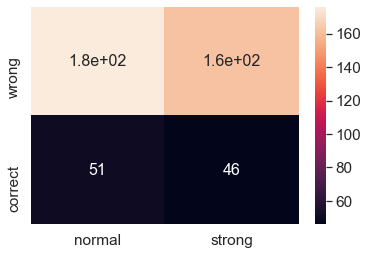

In [49]:
# correlation between emotion intensity and prediction
correct_strong = 0
correct_normal = 0
wrong_strong = 0
wrong_normal = 0
for i in range(len(X_test)):
    intensity = data.loc[test_ind[i],'Intensity']
    if Y_test[i] == predictions[i]: # correct prediction
        if  intensity == 'normal':
            correct_normal += 1
        else:
            correct_strong += 1
    else: # wrong prediction
        if intensity == 'normal':
            wrong_normal += 1
        else:
            wrong_strong += 1
array = np.array([[wrong_normal,wrong_strong],[correct_normal,correct_strong]])
df = pd.DataFrame(array,['wrong','correct'],['normal','strong'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.savefig(
    f'./CNN-lstm/results/correlation_Intensity_correctness.png')
plt.show()

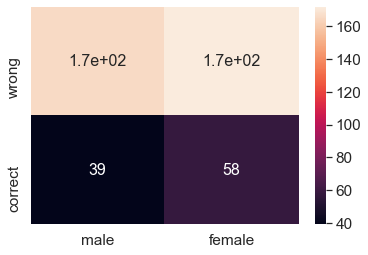

In [48]:
# correlation between gender and corectness
correct_male = 0
correct_female = 0
wrong_male = 0
wrong_female = 0
for i in range(len(X_test)):
    gender = data.loc[test_ind[i],'Gender']
    if Y_test[i] == predictions[i]: # correct prediction
        if  gender == 'male':
            correct_male += 1
        else:
            correct_female += 1
    else: # wrong prediction
        if gender == 'male':
            wrong_male += 1
        else:
            wrong_female += 1
array = np.array([[wrong_male,wrong_female],[correct_male,correct_female]])
df = pd.DataFrame(array,['wrong','correct'],['male','female'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.savefig(
    f'./CNN-lstm/results/correlation_gender_correctness.png')
plt.show()

### Plot loss

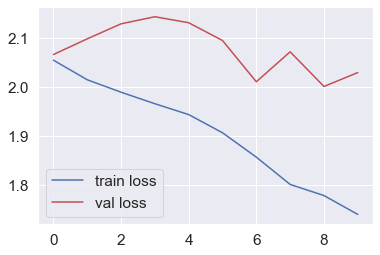

In [46]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.legend(['train loss','val loss'])
plt.savefig(
    f'./CNN-lstm/results/train_test_loss.pdf')